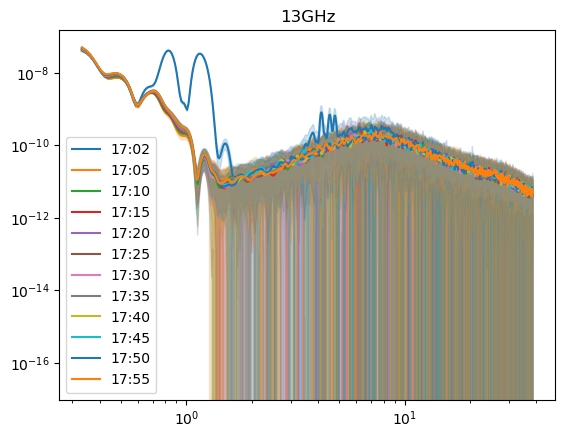

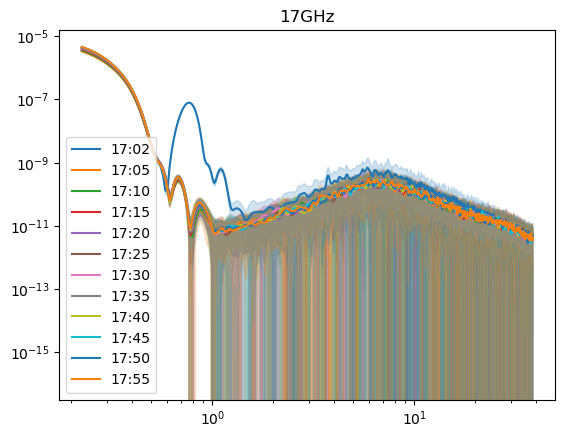

In [6]:
import matplotlib.pyplot as plt 
import glob 
from radar import RadarMesure
import os
import numpy as np

folder = '../data/continuous/'
for j in ['13GHz','17GHz']:

    data=glob.glob(folder+'Calib-Dome-Sirene_20250801/*'+j+'*')

    mes = [(RadarMesure(i)) for i in data]
    mes.sort(key=lambda x: x.time)
    for i in mes :
        df = i.df
        line, = plt.plot(df.index, df.copol, label=i.time.strftime('%H:%M'))
        plt.fill_between(df.index,
                 df.copol - df.copol_std,
                 df.copol + df.copol_std,
                 alpha=0.2,
                 color=line.get_color())

    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    #plt.xlim(0,2)
    plt.title(j)
    plt.show()

In [7]:
mes[0].df

,copol,crosspol,copol_std,crosspol_std
0.226000,3.408560e-06,3.746448e-07,1.478389e-08,5.955439e-09
0.240990,2.939822e-06,1.744140e-07,1.370951e-08,3.844044e-09
0.255979,2.486955e-06,5.057442e-08,1.223322e-08,1.814854e-09
0.270969,2.065047e-06,3.220332e-08,1.052542e-08,1.617784e-09
0.285958,1.685338e-06,1.119267e-07,8.773671e-09,2.796622e-09
...,...,...,...,...
38.524487,3.959592e-12,3.619975e-12,3.924994e-12,3.704607e-12
38.539476,4.177573e-12,3.763584e-12,4.019682e-12,4.129733e-12
38.554466,4.390555e-12,3.910709e-12,4.231351e-12,4.432974e-12
38.569455,4.553082e-12,4.041228e-12,4.493637e-12,4.528351e-12


In [8]:
def extract_all_spectra_to_df(filepath, beta=8, pad_factor=5, polarisation='copol'):
    import numpy as np
    import pandas as pd
    from scipy import signal
    from scipy.fft import fft, fftfreq
    import re

    assert polarisation in ['copol', 'crosspol'], "polarisation doit être 'copol' ou 'crosspol'"

    scaling_factor_adc = (3.3 + 3.3) / (2 ** 12)
    frequence_echantillonage = 10e6
    N = 1024
    T = 1 / frequence_echantillonage
    N_padded = N * pad_factor
    BW = frequence_echantillonage / N_padded

    def kai(N, beta):
        window = signal.windows.kaiser(N, beta=beta)
        S1 = np.sum(window)
        return window, S1

    def freq_to_dist(xf):
        c = 299_792_458  # vitesse de la lumière
        B = 2e9
        ramp_time = 102.4e-6
        dist = xf * c * ramp_time / (2 * B)
        return dist

    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    chirps = []
    current_chirp = []
    current_timestamp = None

    for line in lines:
        if line.startswith("# Chirp Number"):
            if current_chirp:
                chirps.append((current_timestamp, current_chirp))
                current_chirp = []
        elif line.startswith("# Timestamp:"):
            match = re.search(r"(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\.\d+)", line)
            if match:
                current_timestamp = match.group(1)
        elif not line.startswith("#") and line.strip():
            try:
                current_chirp.append([int(x.strip()) for x in line.strip().split(",")])
            except:
                continue  # ignore les lignes mal formées

    if current_chirp:
        chirps.append((current_timestamp, current_chirp))

    spectra_dict = {}
    distances = None
    kaiwindow, s1 = kai(N, beta)

    ch_idx = 1 if polarisation == 'copol' else 0

    for timestamp, chirp_data in chirps:
        if len(chirp_data) < N:
            continue
        chirp_array = np.array(chirp_data[:N])
        if chirp_array.shape[1] < 4:
            continue  # vérification de sécurité

        data_cplx = (chirp_array[:, 2*ch_idx] + 1j * chirp_array[:, 2*ch_idx + 1]) * scaling_factor_adc
        trace = data_cplx * kaiwindow
        trace_padded = np.pad(trace, (0, N_padded - N), 'constant')
        fft_result = fft(trace_padded)
        V2 = np.abs(fft_result[:N_padded // 2]) ** 2 / (s1 ** 2)
        P = V2 / 50
        ps_watt_per_hz = P / BW

        if distances is None:
            xf = fftfreq(N_padded, T)
            distances = freq_to_dist(xf[:N_padded // 2])

        spectra_dict[pd.to_datetime(timestamp)] = ps_watt_per_hz

    df_final = pd.DataFrame(spectra_dict, index=distances)
    df_final.index.name = "distance_m"
    return df_final

In [65]:

def process_all_files(folder, polarisation='copol', max_distance=30):
    """
    Pour chaque fichier radar :
    - extrait le spectre moyen (sur le temps)
    - regroupe par fréquence
    - trace tous les spectres moyens (1 courbe = 1 fichier)
    """
    sns.set(style="whitegrid")
    files = sorted(glob.glob(folder + '/*.txt'))
    spectres = {'13GHz': [], '17GHz': []}

    for filepath in files:
        try:
            df = extract_all_spectra_to_df(filepath, polarisation=polarisation)
            df_mean = df.mean(axis=1)

            freq = '13GHz' if '13GHz' in filepath else '17GHz'
            label = os.path.basename(filepath).split('_')[-1].replace('.txt', '')
            spectres[freq].append((label, df_mean))
        except Exception as e:
            print(f"[WARNING] Erreur avec {filepath}: {e}")

    # === Plot ===
    for freq, traces in spectres.items():
        plt.figure(figsize=(10, 6))
        for label, trace in traces:
            trace_cut = trace[trace.index < max_distance]
            plt.plot(trace_cut.index, trace_cut.values, label=label)

        plt.xlim(0.2,2)
        plt.xscale('log')
        plt.yscale('log')
        plt.title(f"Spectres moyens - {freq} ({polarisation})")
        plt.xlabel("Distance (m)")
        plt.ylabel("Spectre moyen (W/Hz)")
        plt.legend(title="Heure", fontsize=8)
        plt.tight_layout()
        plt.savefig(f"/home/nicolas/Documents/Dku-toolbox/fig/hourvariability{freq}.png")
        plt.show()

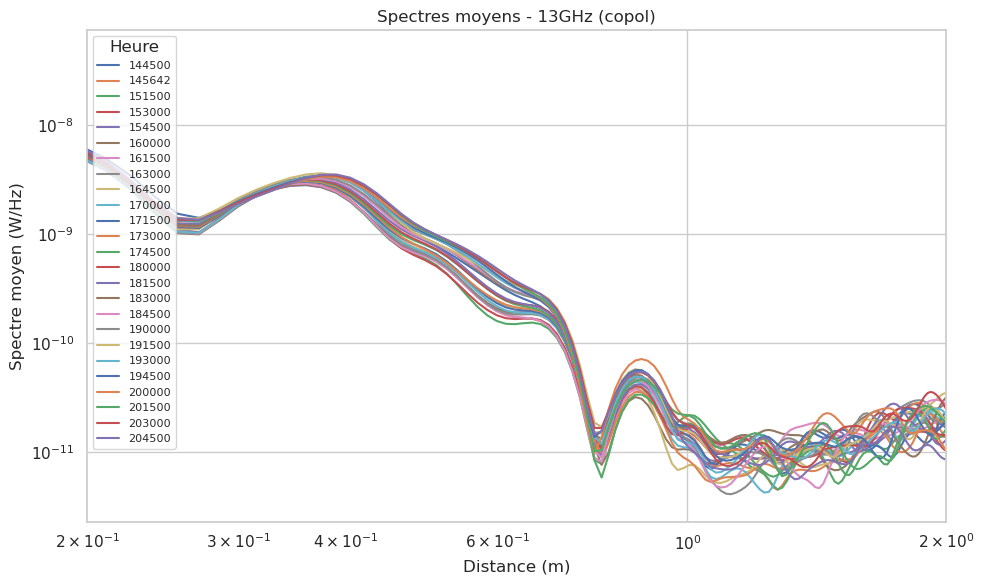

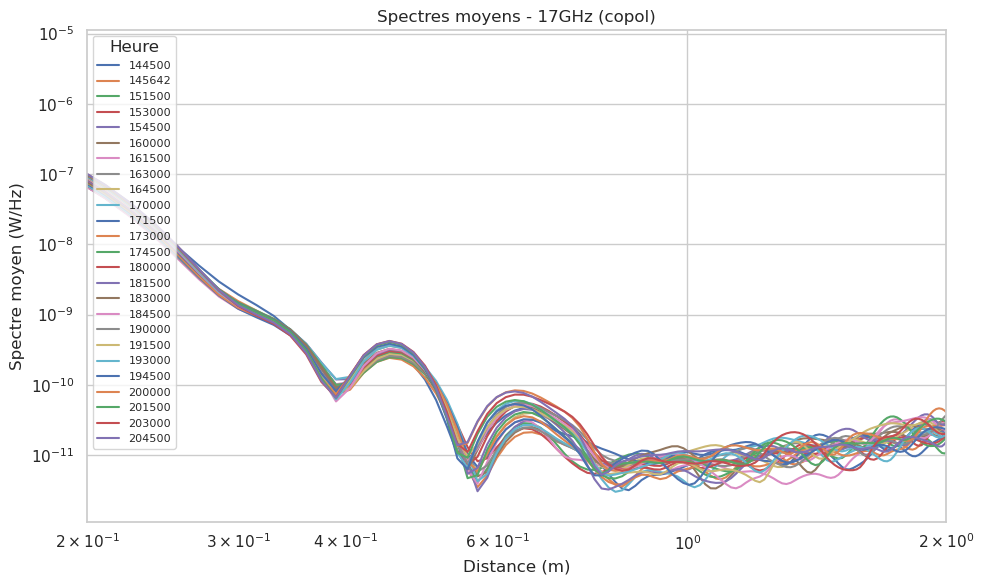

In [66]:
process_all_files(
    folder='/home/nicolas/Documents/Dku-toolbox/data/continuous/calib_sky_20250804',
    polarisation='copol'
)


In [67]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def save_dual_frequency_plots(files, polarisation='copol', max_distance=30, out_dir="/home/nicolas/Documents/Dku-toolbox/fig/subminutevariability"):
    """
    Pour chaque timestamp (13GHz + 17GHz), trace les courbes de chaque chirp pour les 2 fréquences
    et enregistre la figure dans out_dir.
    """
    sns.set(style="whitegrid")
    os.makedirs(out_dir, exist_ok=True)

    # Indexer les fichiers par timestamp
    file_dict = {}
    for f in files:
        basename = os.path.basename(f)
        parts = basename.split('_')
        if len(parts) < 4:
            continue
        freq = '13GHz' if '13GHz' in basename else '17GHz'
        timestamp = parts[-1].replace('.txt', '')  # e.g., 144500
        file_dict.setdefault(timestamp, {})[freq] = f

    for timestamp, freq_files in file_dict.items():
        if '13GHz' not in freq_files or '17GHz' not in freq_files:
            continue  # skip if one of the two frequencies is missing

        try:
            df_13 = extract_all_spectra_to_df(freq_files['13GHz'], polarisation=polarisation)
            df_17 = extract_all_spectra_to_df(freq_files['17GHz'], polarisation=polarisation)

            fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
            for ax, df, freq in zip(axes, [df_13, df_17], ['13GHz', '17GHz']):
                for ts in df.columns:
                    y = df[ts]
                    y = y[y.index < max_distance]
                    ax.plot(y.index, y.values, linewidth=1, alpha=1)
                ax.set_title(f"{freq} – {polarisation}")
                ax.set_xlabel("Distance (m)")
                ax.set_xscale('log')
                ax.set_yscale('log')
                ax.grid(True)

            axes[0].set_ylabel("Spectre (W/Hz)")
            fig.suptitle(f"Sub-minute Variability – {timestamp} – {polarisation}", fontsize=14)
            plt.tight_layout(rect=[0, 0, 1, 0.95])

            # Save figure
            out_path = os.path.join(out_dir, f"{timestamp}_{polarisation}.png")
            plt.savefig(out_path, dpi=200)
            plt.close()
            print(f"✅ Enregistré : {out_path}")

        except Exception as e:
            print(f"[⚠️] Erreur pour {timestamp}: {e}")

In [68]:
folder = '/home/nicolas/Documents/Dku-toolbox/data/continuous/calib_sky_20250804'
all_files = glob.glob(folder + '/*.txt')

save_dual_frequency_plots(all_files, polarisation='copol')
save_dual_frequency_plots(all_files, polarisation='crosspol')


✅ Enregistré : /home/nicolas/Documents/Dku-toolbox/fig/subminutevariability/171500_copol.png
✅ Enregistré : /home/nicolas/Documents/Dku-toolbox/fig/subminutevariability/164500_copol.png
✅ Enregistré : /home/nicolas/Documents/Dku-toolbox/fig/subminutevariability/163000_copol.png
✅ Enregistré : /home/nicolas/Documents/Dku-toolbox/fig/subminutevariability/153000_copol.png
✅ Enregistré : /home/nicolas/Documents/Dku-toolbox/fig/subminutevariability/194500_copol.png
✅ Enregistré : /home/nicolas/Documents/Dku-toolbox/fig/subminutevariability/144500_copol.png
✅ Enregistré : /home/nicolas/Documents/Dku-toolbox/fig/subminutevariability/191500_copol.png
✅ Enregistré : /home/nicolas/Documents/Dku-toolbox/fig/subminutevariability/184500_copol.png
✅ Enregistré : /home/nicolas/Documents/Dku-toolbox/fig/subminutevariability/204500_copol.png
✅ Enregistré : /home/nicolas/Documents/Dku-toolbox/fig/subminutevariability/161500_copol.png
✅ Enregistré : /home/nicolas/Documents/Dku-toolbox/fig/subminutevariab